In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")
import matplotlib.pyplot as plt
from src.metrics import StratifiedRCU
from src.viz import ExperimentVisualizer
from pathlib import Path
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

In [2]:
RESDIR = "results/cloud_exp/2023-05-26_15-55-46"
S2DIR = "gee_data/reprojected/"
GTDIR = "assets/data/preprocessed"

In [3]:
# Experiment result directories
result_dirs = [p.path for p in os.scandir(RESDIR) if os.path.exists(os.path.join(p.path,"rcu.json"))]
result_dirs

['results/cloud_exp/2023-05-26_15-55-46/1023_20180824T105019',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180523T104019',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180610T105031',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180503T104019',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180908T105021',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180531T105031',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180620T105031',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180806T104021',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180426T105029',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180428T104021',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180905T104021',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180416T105029',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180829T105031',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180516T105029',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180831T104019',
 'results/cloud_exp/2023-05-26_15-55-46/1023_20180511T1

In [4]:
# Compute average cloud proba in each image
exp_vars = []
image_paths = []
for result_dir in result_dirs:
    project_id, image_ts = result_dir.split("/")[-1].split("_")
    ps2_dir = Path(os.path.join(S2DIR, project_id))
    found = False
    for image_path in ps2_dir.glob("*.tif"):
        if image_path.stem.split("_")[3]==image_ts:
            with rasterio.open(image_path) as f:
                data = f.read(f.count).astype("float")
                exp_vars.append(data.mean())
            image_paths.append(image_path)
            found = True
            break
    if not found: raise ValueError(f"Could not find image for {result_dir}")
exp_vars

[77.09280344858915,
 0.3415712028623999,
 11.893006428433724,
 42.85628244039683,
 90.62815651016487,
 0.29645878467664677,
 0.0,
 32.70608178728628,
 20.055098908355486,
 57.67788361750265,
 97.79379633616949,
 97.88917211848764,
 96.22429272825445,
 13.054695238468078,
 0.3188571082463147,
 94.32926721173797,
 6.541122992637918,
 0.2721130216593085]

In [5]:
visualizer = ExperimentVisualizer.from_paths(
    result_dirs,
    "avg_cloud_prob",
    exp_vars,
    ['P95', 'MeanH', 'Dens', 'Gini', 'Cover'],
    fig_ncols=1
)

# Visual results
- Show RGB, show cloud mask, cloud_threshold mask with 0.1/10 (0: pixel rejected, 1: pixel kept)
- Compute fraction of cloudy pixels
- Show gt, mean, uncertainty, regression error, calibration error for each variables

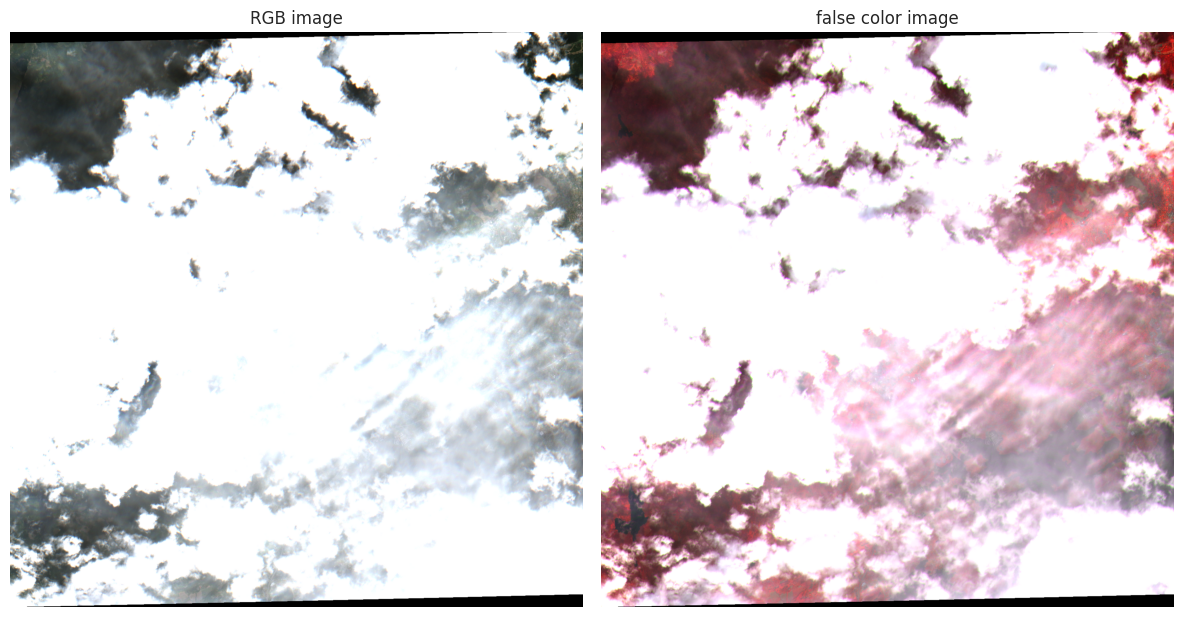

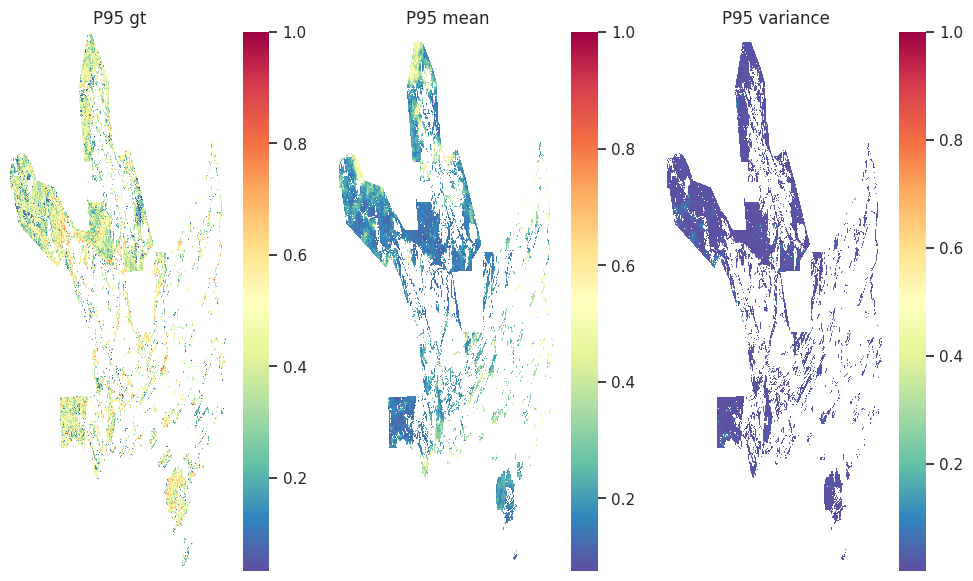

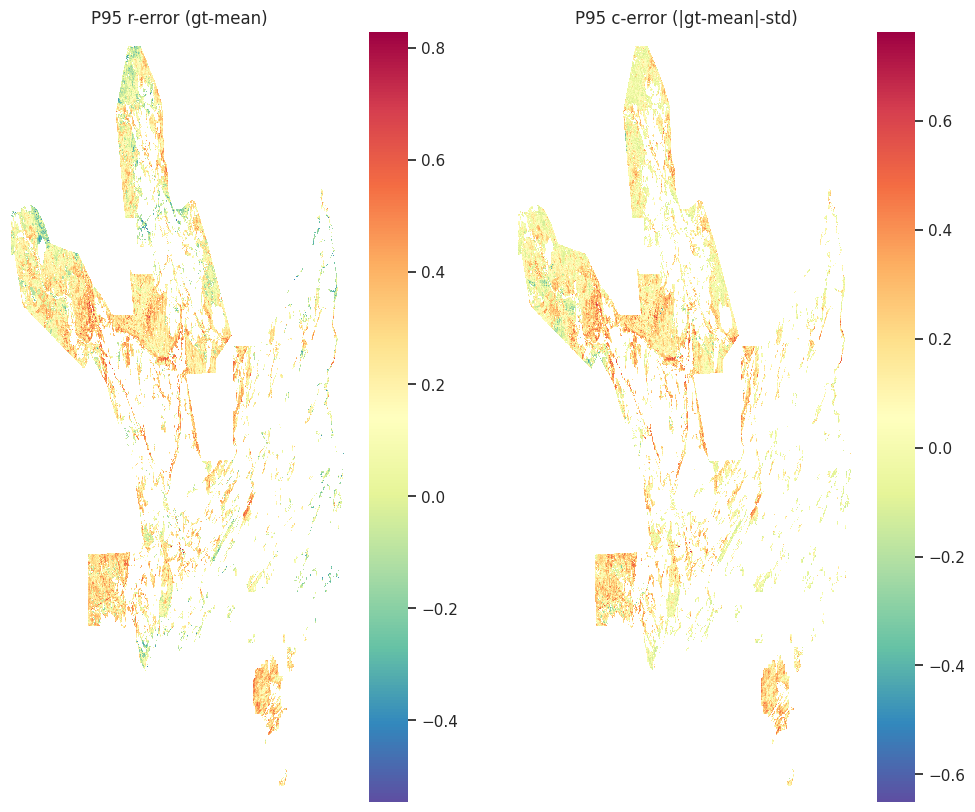

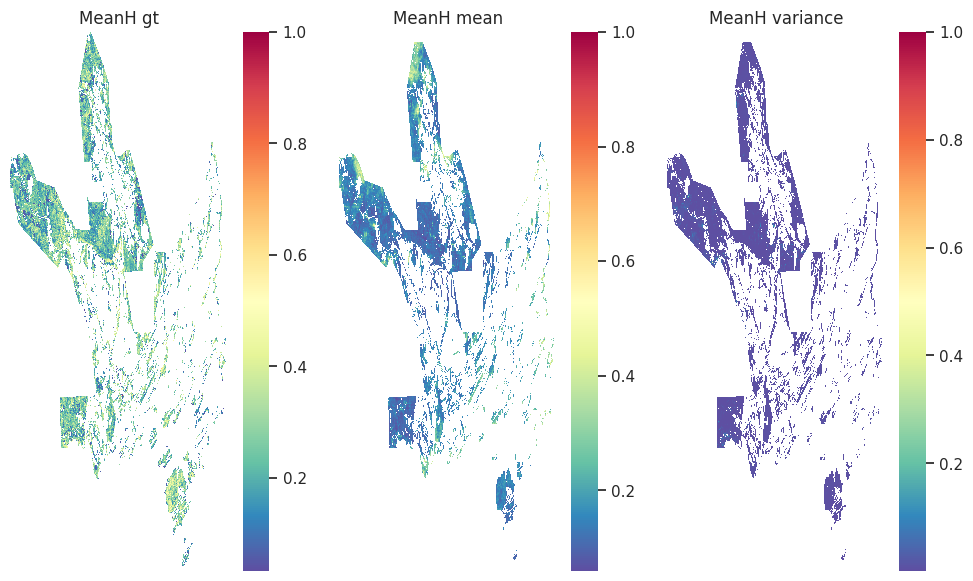

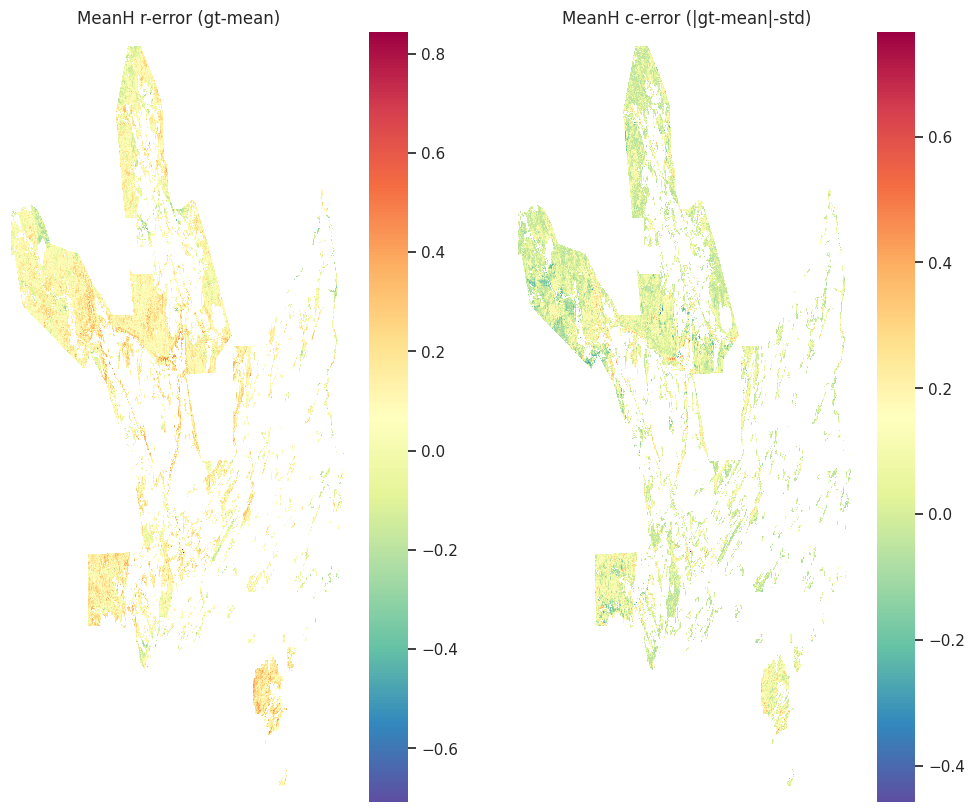

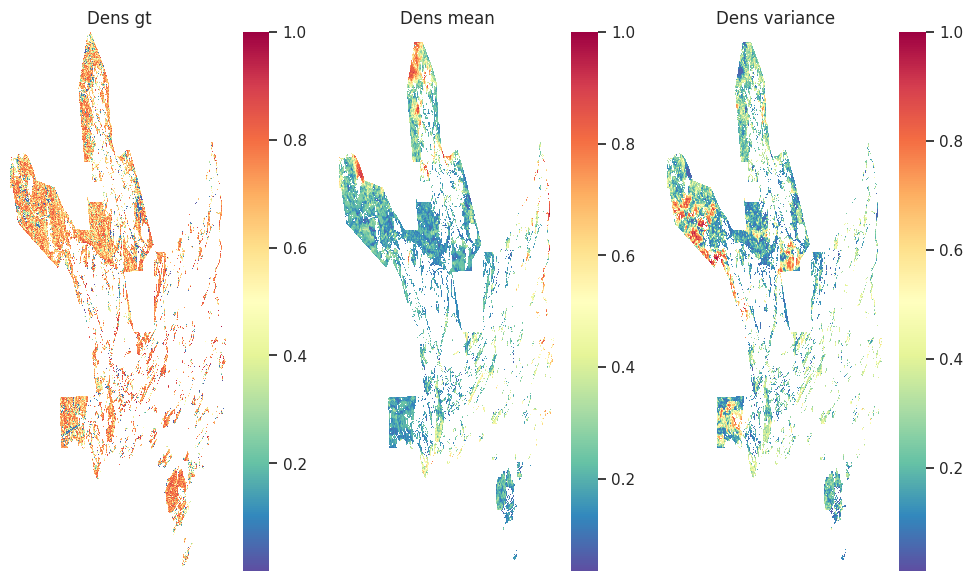

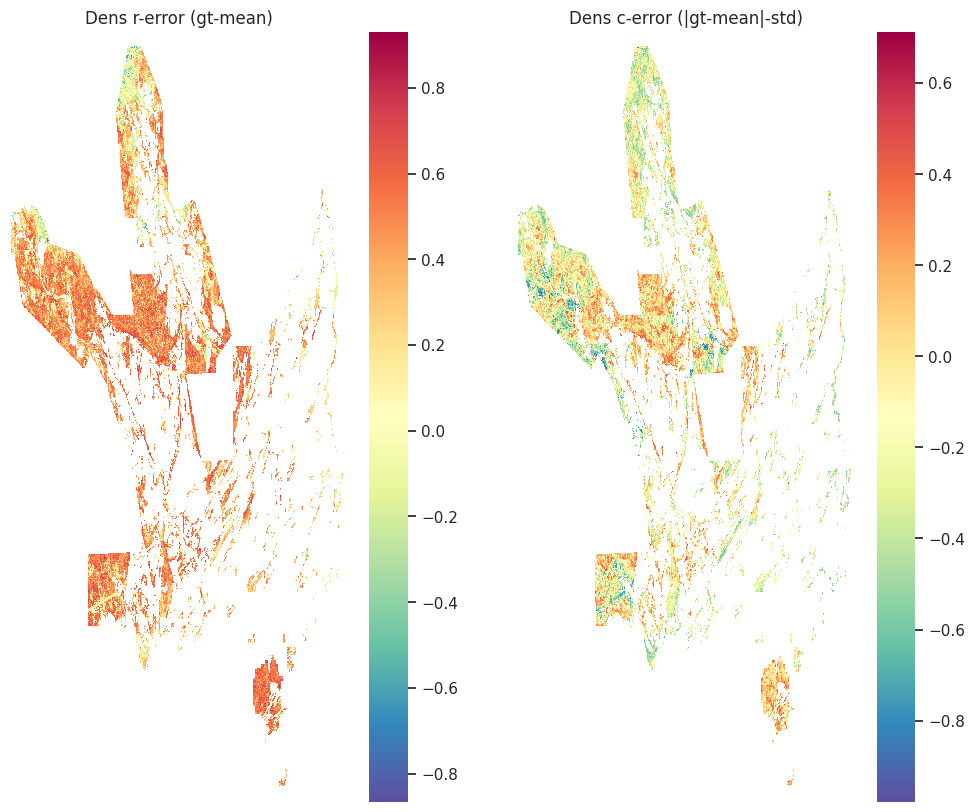

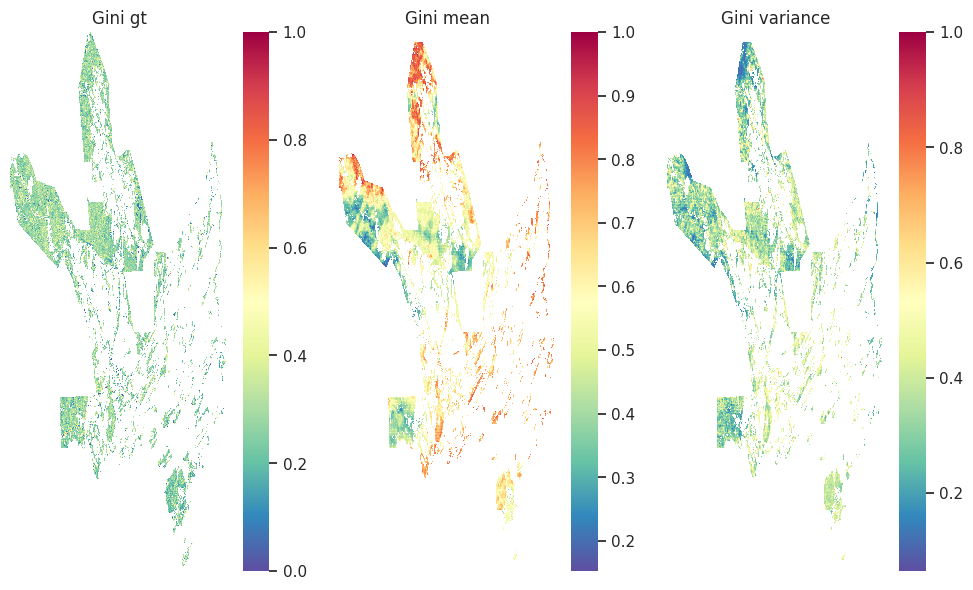

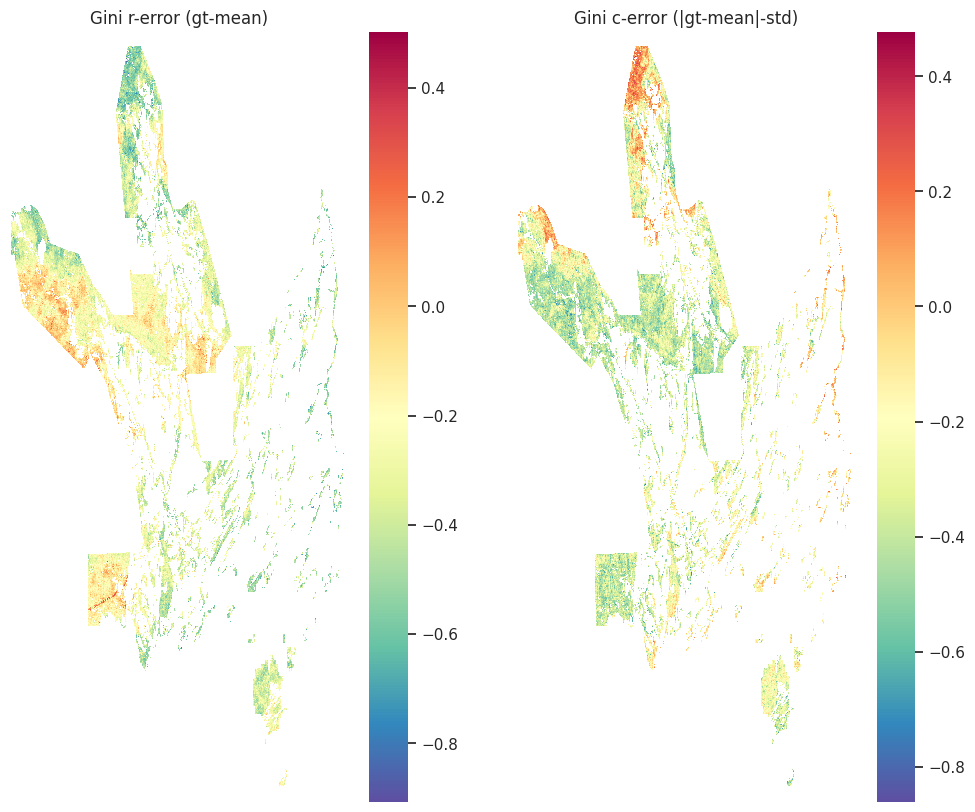

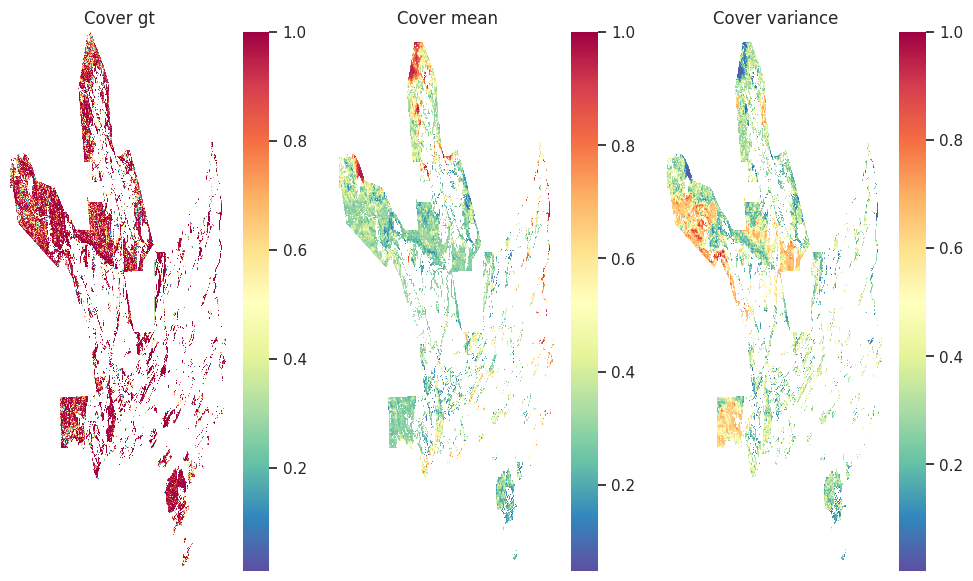

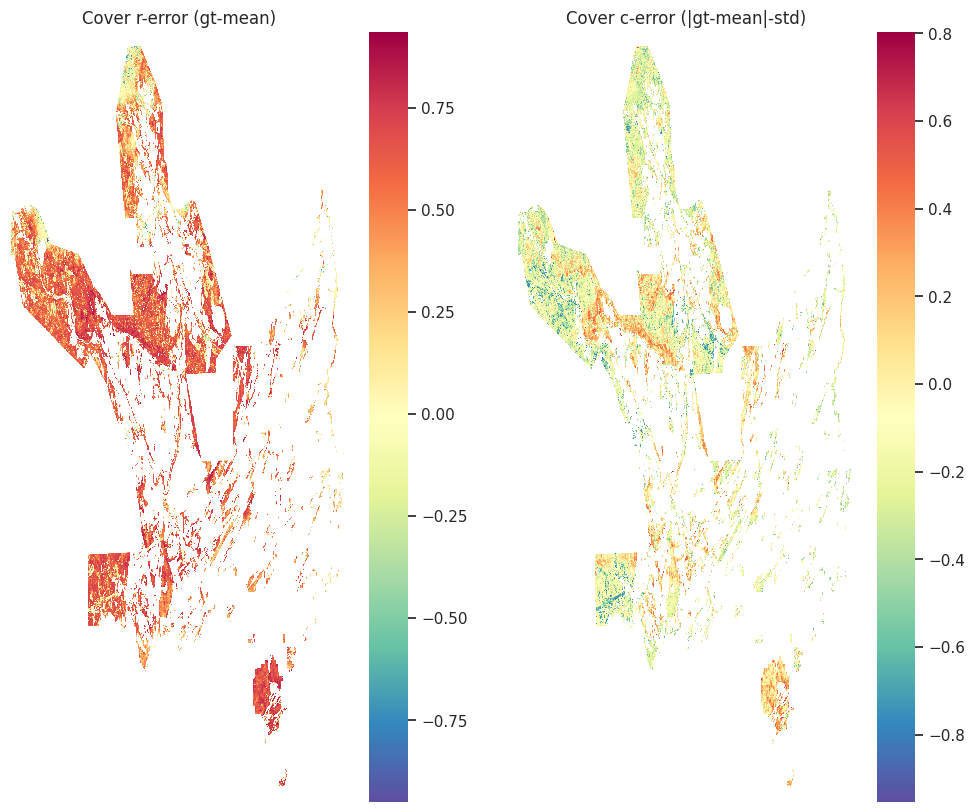

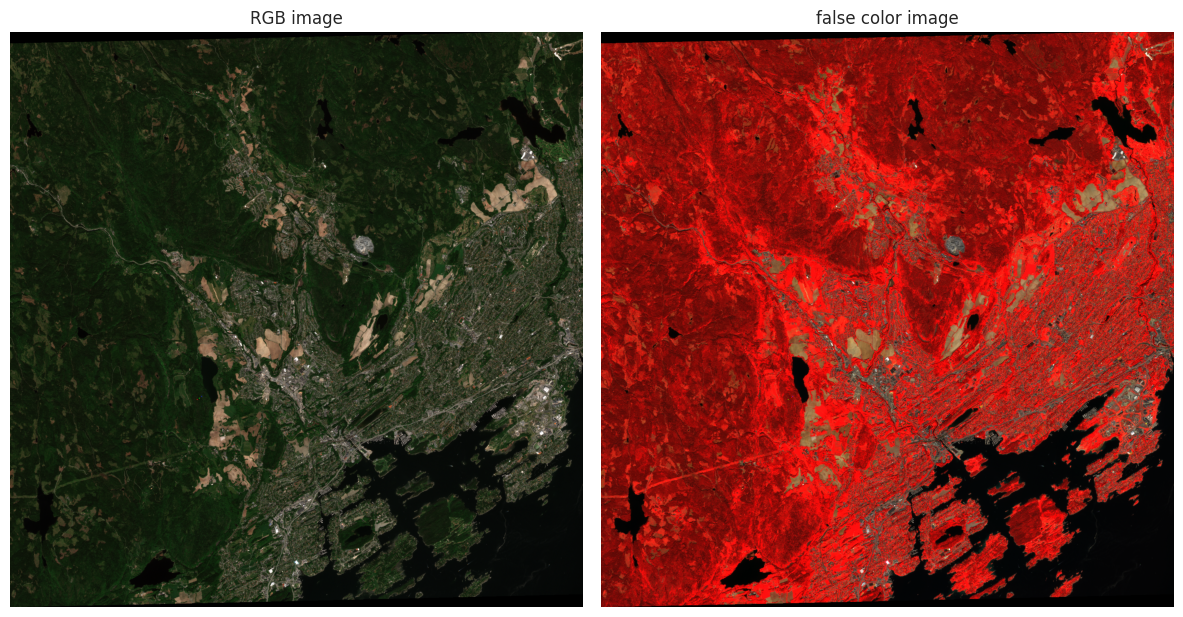

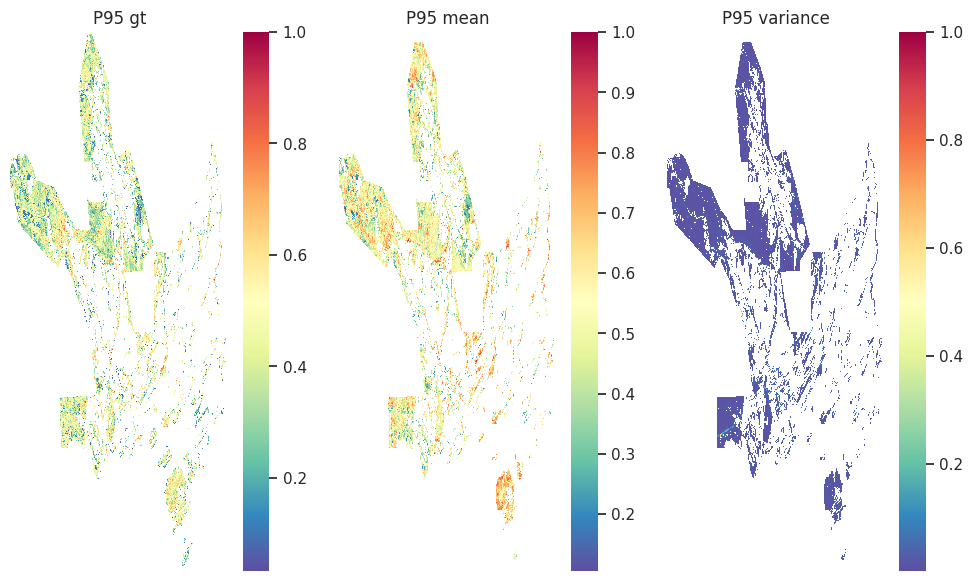

In [ ]:
def clip(arr, bounds):
    bounds = (float(bounds[0]), float(bounds[1]))
    arr = np.where(arr>bounds[1], bounds[1], arr)
    arr = np.where(arr<bounds[0], bounds[0], arr)
    arr /= bounds[1]
    return arr

for i, (image_path, result_dir) in enumerate(zip(image_paths, result_dirs)):
    with rasterio.open(image_path) as rf:
        rgb = rf.read([4,3,2]).astype("float").transpose(1,2,0)
        fc = rf.read([8,4,2]).astype("float").transpose(1,2,0)
    project_id = result_dir.split("/")[-1].split("_")[0]
    with rasterio.open(os.path.join(result_dir, f"{project_id}_mean.tif")) as mf:
        mean = mf.read([1,2,3,4,5])
    with rasterio.open(os.path.join(result_dir, f"{project_id}_variance.tif")) as vf:
        variance = vf.read([1,2,3,4,5])
    with rasterio.open(os.path.join(GTDIR, f"{project_id}.tif")) as gf:
        gt = gf.read([1,2,3,4,5])
        gt_mask = gf.read_masks(1)//255
    gt[:,gt_mask==0]=np.nan
    # normalize for plot
    mean /= np.nanmax(mean, axis=(1,2), keepdims=True)
    variance /= np.nanmax(variance, axis=(1,2), keepdims=True)
    gt /= np.nanmax(gt, axis=(1,2), keepdims=True)
    # images
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
    axs[0].imshow(clip(rgb, bounds=(0, 3000)))
    axs[0].set_title("RGB image")
    axs[1].imshow(clip(fc, bounds=(0,4000)))
    axs[1].set_title("false color image")
    for ax in axs:
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()    
    # metrics and values
    for i, (g, m, v, variable) in enumerate(zip(gt, mean, variance, ['P95', 'MeanH', 'Dens', 'Gini', 'Cover'])):
        # values
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,7))
        sns.heatmap(g, ax=axs[0], cmap="Spectral_r")
        axs[0].set_title(f"{variable} gt")
        sns.heatmap(m, ax=axs[1], cmap="Spectral_r")
        axs[1].set_title(f"{variable} mean")
        sns.heatmap(v, ax=axs[2], cmap="Spectral_r")
        axs[2].set_title(f"{variable} variance")
        for ax in axs: ax.set_axis_off()
        plt.show()
        # metrics
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))
        sns.heatmap(g-m, ax=axs[0], cmap="Spectral_r")
        axs[0].set_title(f"{variable} r-error (gt-mean)")
        sns.heatmap(np.abs(g-m)-np.sqrt(v), ax=axs[1], cmap="Spectral_r")
        axs[1].set_title(f"{variable} c-error (|gt-mean|-std)")
        for ax in axs: ax.set_axis_off()
        plt.show()

# Quantitative results

## Dataset informations

In [ ]:
# Sample size
data = {visualizer.exp_var_name: [], "count": []}
for i, rcu in enumerate(visualizer.rcus):
    count = np.nansum(rcu.histogram[0,0])
    data[visualizer.exp_var_name].append(visualizer.exp_vars[i])
    data["count"].append(count)
pd.DataFrame(data).sort_values(by=["avg_cloud_prob"])

In [ ]:
# Histogram: we expect less low variance estimates when the cloud proba increases
visualizer.histogram_plot(log=False)
plt.tight_layout()
plt.show()

In [ ]:
# Trimmed histogram
visualizer.histogram_plot(hi_bound=[250, 250, 0.14, 0.015, 0.25], log=False)
plt.tight_layout()
plt.show()

## Metrics

In [ ]:
# rmse (min): Should increase as the data shift to unseen territories
axs = visualizer.metric_plot("rmse", "agg")
plt.tight_layout()
plt.show()

In [ ]:
# uce (min): should stay constant if calibration is consistent
axs = visualizer.metric_plot("uce", "agg")
plt.tight_layout()
plt.show()

In [ ]:
# auce (min): should stay constant if calibration is consistent
axs = visualizer.metric_plot("auce", "agg")
plt.tight_layout()
plt.show()

In [ ]:
# srp (min): Should increase as the model should be less confident, i.e. produce higher mean variance estimates
axs = visualizer.metric_plot("srp", "agg")
plt.tight_layout()
plt.show()

In [ ]:
# cv (max): As the variance estimates distribution is heavy-tailed, we expect Cv to increase 
axs = visualizer.metric_plot("cv", "agg")
plt.tight_layout()
plt.show()

## Calibration curves

In [ ]:
visualizer.calibration_plot("ence", log_bins=False)
plt.tight_layout()
plt.show()

In [ ]:
visualizer.calibration_plot("ence", log_bins=True)
plt.tight_layout()
plt.show()

In [ ]:
visualizer.calibration_plot("auce", log_bins=True)
plt.tight_layout()
plt.show()